# **Explanable Framework for the Neural Network Prediction**

This notebook elaborate a comprehensive step by step process for explaining the previous [neural network model](https://github.com/LgendSourabie/explainable-deep-learning-framework/blob/main/notebooks/neural_network_training.ipynb) introduce in **neural_network_training.ipynb** and includes:


-   Introduction
-   Global explanations: What features generally drive the model’s decisions?
-   Local explanations: Why did the model make this specific prediction?
-   Multiple explanation tools: [SHAP](https://shap.readthedocs.io/en/latest/), [LIME](https://lime-ml.readthedocs.io/en/latest/), and supporting visualizations.


# 1. **Introduction**

---
# Explainability in Machine Learning for Model Prediction

Machine learning models (like neural networks) can achieve high predictive accuracy, but their decision-making process is often complex and "black box". Explainability is crucial for:
- **Acceptance:** Understanding and trusting the model’s reasoning is essential for research and further discovery.
- **Industrial adoption:** Stakeholders require justifications for decisions, especially when outcomes have safety, quality, or financial implications.

### What is Explainability?
- **Global Explanation:** Understanding what factors (features) the model uses overall—“Which features matter the most in general?”
- **Local Explanation:** Understanding why a particular prediction was made “Why did the model classify this specific sample as class 2?”

### Acceptable Explanations
An acceptable explanation need to be:
- **Faithful:** Accurately reflect the true logic of the model.
- **Consistent:** Similar explanations for similar cases.
- **Actionable:** Can guide further research or process adjustments.
- **Human-understandable:** Easily interpreted by experts and non-experts.

#### Tools Used
**SHAP (SHapley Additive exPlanations):** Based on game theory, assigns each feature a value representing its contribution to a particular prediction or overall outcome.


# **2. Loading Data and Model**

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import os
import joblib
from tensorflow.keras.models import load_model
from IPython.display import display
from scipy.stats import binned_statistic
from pathlib import Path

/home/sourabie/Thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-23 23:17:01.434958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763936221.468550 2947159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763936221.479288 2947159 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-23 23:17:01.557402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical 

## Loading Data form Previous Step (Data Preparation)

In [ ]:
SAVE_DIR = Path("../output/data_preparation_outputs")

if SAVE_DIR.exists():
    scaler = joblib.load(SAVE_DIR / 'scaler.joblib')
    test_specimen_name = np.load(SAVE_DIR / 'name.npy')
    ra = np.load(SAVE_DIR / 'ra.npy')
else:
    raise Exception("File could not be found")

SAVE_DIR = Path("../output/training_outputs")

# Loading test data and model
if SAVE_DIR.exists():
    X_test = np.load(SAVE_DIR / 'X_test.npy')
    X_train = np.load(SAVE_DIR / 'X_train.npy')
    y_test = np.load(SAVE_DIR / 'y_test.npy')
    idx_train = np.load(SAVE_DIR / 'idx_train.npy')
    idx_test = np.load(SAVE_DIR / 'idx_test.npy')
    surface_roughness_ra_train = np.load(SAVE_DIR / 'surface_roughness_ra_train.npy')
    surface_roughness_ra_test = np.load(SAVE_DIR / 'surface_roughness_ra_test.npy')
    names_train = np.load(SAVE_DIR / 'names_train.npy')
    names_test = np.load(SAVE_DIR / 'names_test.npy')
    trained_model = load_model(SAVE_DIR / 'nn_model.h5')
else:
    raise Exception(SAVE_DIR / "File could not be found")


# Loading feature names
FILE_PATH = '../data/Kochmesser_ohne_prozessdaten.xlsx'
features = pd.read_excel(FILE_PATH).loc[:, 'Ra_ganz':'DFT_Median_sobel_Bereich'].columns
# X_test_df = pd.DataFrame(X_test[:20], columns=features)
X_test_df = pd.DataFrame(X_test, columns=features)

# Predict class for each rows in our dataset
probs = trained_model.predict(X_test)
y_pred = probs.argmax(axis=1)

W0000 00:00:1763936223.015370 2947159 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


# **3. Implementation of SHAP for our dataset**

**SHAP** assigns an importance value (Shapley value) to each feature, representing its contribution to the model's prediction for every instance.  
- **Global Explanation** is obtained by summarizing the SHAP values across all test data, indicating which features the model considers most important overall.

*Reference:*  
- Lundberg, S. M., & Lee, S. I. (2017). "A unified approach to interpreting model predictions." NeurIPS.
- SHapley Additive exPlanations [Paper, 2017](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)

**Advantages:**
- Mathematical explanation (based on game theory)
- Works with any model
- Provides both local (per prediction) and global (overall) explanations

In [3]:
SAVE_DIR = Path("../output/explanation_output")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

if os.path.exists(SAVE_DIR / 'shap_values.joblib'):
    shap_values = joblib.load(SAVE_DIR / 'shap_values.joblib')
    expected_value = np.load(SAVE_DIR / 'expected_value.npy', allow_pickle=True)

else:
    explainer = shap.KernelExplainer(trained_model.predict, background)
    shap_values = explainer.shap_values(X_test)
    joblib.dump(shap_values, SAVE_DIR / 'shap_values.joblib')
    expected_value = np.array(explainer.expected_value)
    np.save(SAVE_DIR / 'expected_value.npy', np.array(explainer.expected_value))

shap_values_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])]


### **3.1. Local Explanation with SHAP**

To gain trust and practical understanding, we examine *why* a particular sample (knife) received a specific prediction.
All the plot here are based on the official documentation of SHAP

#### **Waterfall plot**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class probabilities: [4.1747266e-01 5.8252734e-01 3.1295964e-09]
Predicted class: 1
True class: 0


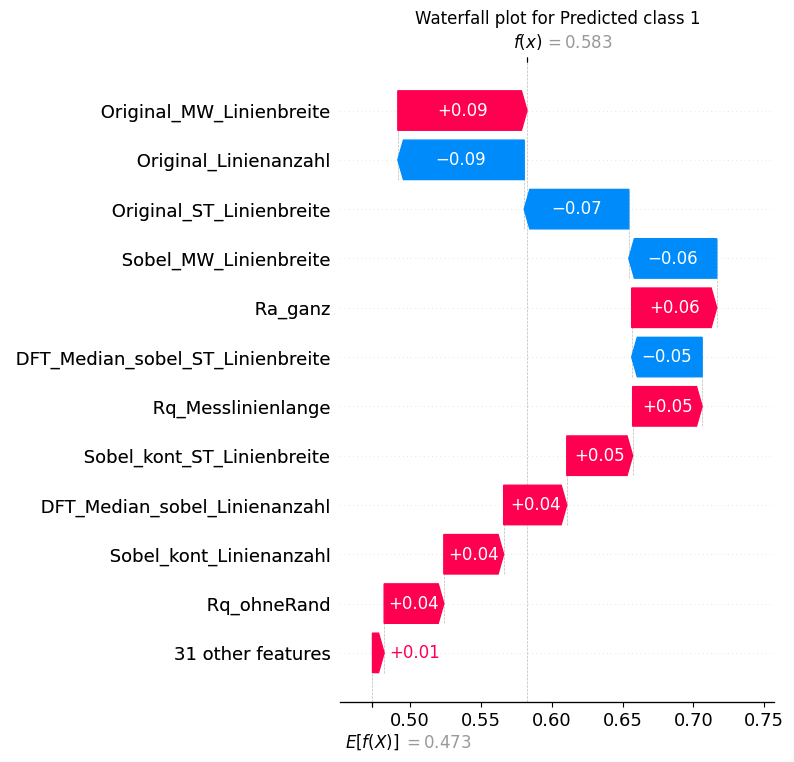

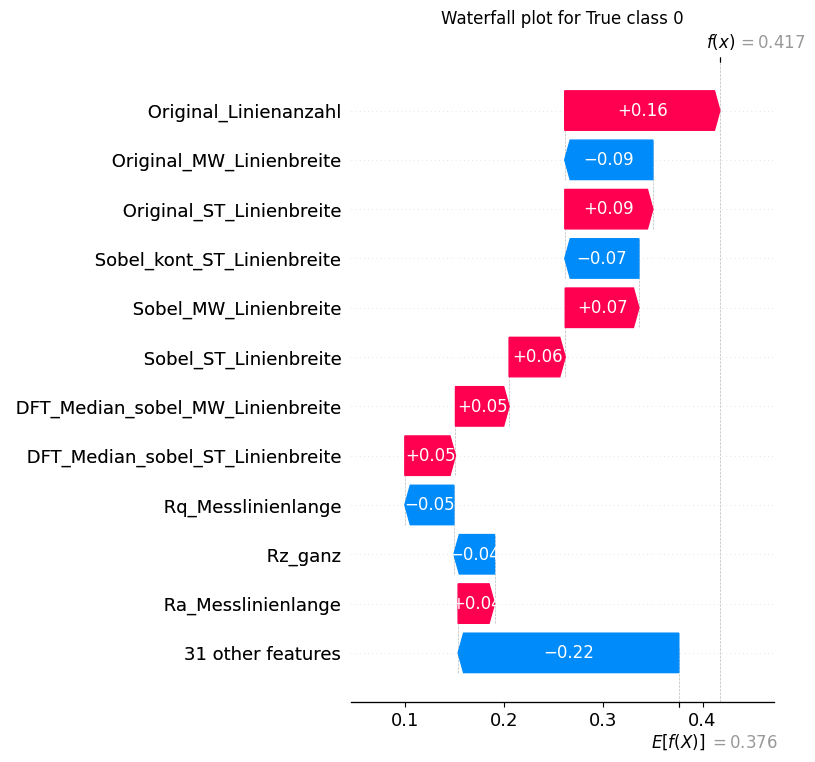

In [4]:
import matplotlib.pyplot as plt

def plot_true(true_class, sample_idx,sample):

    shap.plots._waterfall.waterfall_legacy(
        expected_value[true_class],
        shap_values_list[true_class][sample_idx],
        feature_names=features,
        features=sample,
        max_display=12,
        show=False
    )

def plot_pred(pred_class, sample_idx,sample):
    # Predicted class explanation
    shap.plots._waterfall.waterfall_legacy(
        expected_value[pred_class],
        shap_values_list[pred_class][sample_idx],
        feature_names=features,
        features=sample,
        max_display=12, 
        show=False
    )

def waterfall_plot(sample_idx=0):

    probs = trained_model.predict(X_test[sample_idx].reshape(1, -1))[0]
    pred_class = probs.argmax()
    true_class = y_test[sample_idx]

    print("Predicted class probabilities:", probs)
    print("Predicted class:", pred_class)
    print("True class:", true_class)

    sample = X_test_df.iloc[sample_idx]

    plot_pred(pred_class=pred_class,sample_idx=sample_idx,sample=sample)
    plt.tight_layout()
    plt.title(label=f"Waterfall plot for Predicted class {pred_class}",loc='center')
    plt.show()
    plot_true(true_class=true_class,sample_idx=sample_idx,sample=sample)
    plt.tight_layout()
    plt.title(label=f"Waterfall plot for True class {true_class}",loc='center')
    plt.show()

waterfall_plot(sample_idx=0)

- E(f(x)) is the average model prediction for the class across all samples
- It represents the probability the model would predict if it had no information about this sample's features—only the dataset average.
- f(x) is the final model prediction for this sample and class.
- The feature "original_linienzahl" increased the prediction by 0.22 units

#### Interpretation
In the SHAP waterfall plot, each feature’s SHAP value quantifies how much it pushes the model’s output away from the average prediction (E[f(x)]) toward the final prediction (f(x)). For example, a SHAP value of +0.28 for "original_linienzahl" means that this feature increases the predicted probability (or logit) for this class by 0.28, making it one of the most influential features for this specific decision.

#### **Force plot for fasle predicted output by model to understand what drive the prediction to fail**

The **SHAP force plot** shows how each feature in that instance contributed to the final predicted class probability.

In [5]:
def force_plot(array_of_indexes):
    shap.initjs()

    for idx in array_of_indexes:
        pred_class = y_pred[idx] 
        print(f"\nForce plot for misclassified sample_idx: {idx} (predicted: {pred_class}, true: {y_test[idx]})")
        force_plot = shap.force_plot(
            expected_value[pred_class],
            shap_values_list[pred_class][idx].reshape(1, -1),
            X_test[idx].reshape(1, -1),
            feature_names=features,
            show=False
        )
        display(force_plot)

force_plot([1])


Force plot for misclassified sample_idx: 1 (predicted: 2, true: 2)


#### Interpretation
  
The SHAP force plot provides a visual explanation of how each feature of this specific sample contributed to the predicted probability for class 1. Red bars indicate features that push the prediction higher, blue bars push it lower.

- **Red features:** Increase the predicted probability for the class.
- **Blue features:** Decrease the predicted probability for the class.
- This provides a precise explanation for this sample's prediction, crucial for quality assurance or failure investigation in industrial settings.

### **Identification of icorrect prediction**

In [6]:
misclassified_mask = (y_pred != y_test)
misclassified_indices = np.where(misclassified_mask)[0]
misclassified_lines = idx_test[misclassified_indices]
misclassified_surface_roughness = surface_roughness_ra_test[misclassified_indices]

print(f"Number of samples in test set: {len(y_test)}")
print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Indexes of misclassified samples: {misclassified_lines}")
# print(f"Misclassified surface roughness: {misclassified_surface_roughness}")

Number of samples in test set: 1702
Number of misclassified samples: 478
Indexes of misclassified samples: [7191  197 4727 3725 7367 3808 7545 3076 4930  653 1657 8109 3785 8290
 7437 5132 5784 1632 6953 4264 4050  556 7267 4141 7948 1114 3902 4606
  442 8188 4195 7593 7159 2411  784 8105 5428 7364  162 8242  412 8294
 1112 7378 2541 5704 5443 8212 7935 7477  201 3416 6883 8339 3043 3433
 7570 7283 1715 2011 1701 8229 8421 1208 3035 2919 8192 7626 5038 2594
 5886 8178 1608 1188 7572 1792 3922 7480 7906 6477 5877 2413 2445 7345
 2423 4135 6886 1095 5061 1687 8143 3628 8052  439 7993 5202 2753 3928
 5451 3873   40 1030 5773 5085 2417 1348 2967 7994 4322 4950 3946 7042
 4245 6304 4026 3599 2929 8313 6476 2192 1667 1563 5833 2709 7527 4550
 3783 4224 3021 8478 7555 3571 2069 5060 1378 4867 3286 7988 8296 5771
 2988 3404 1855 7592 8315 7563 7249 1420  141 2426 1421 5002  865 8479
  785 1823 8080 7432 4221 7388 8243  970 7702 8476 4609 7344 2486 6279
 4706 1011 7048 7347 3788  416 3573 1355 

### Identification of failed predictions in batch of 10 knives

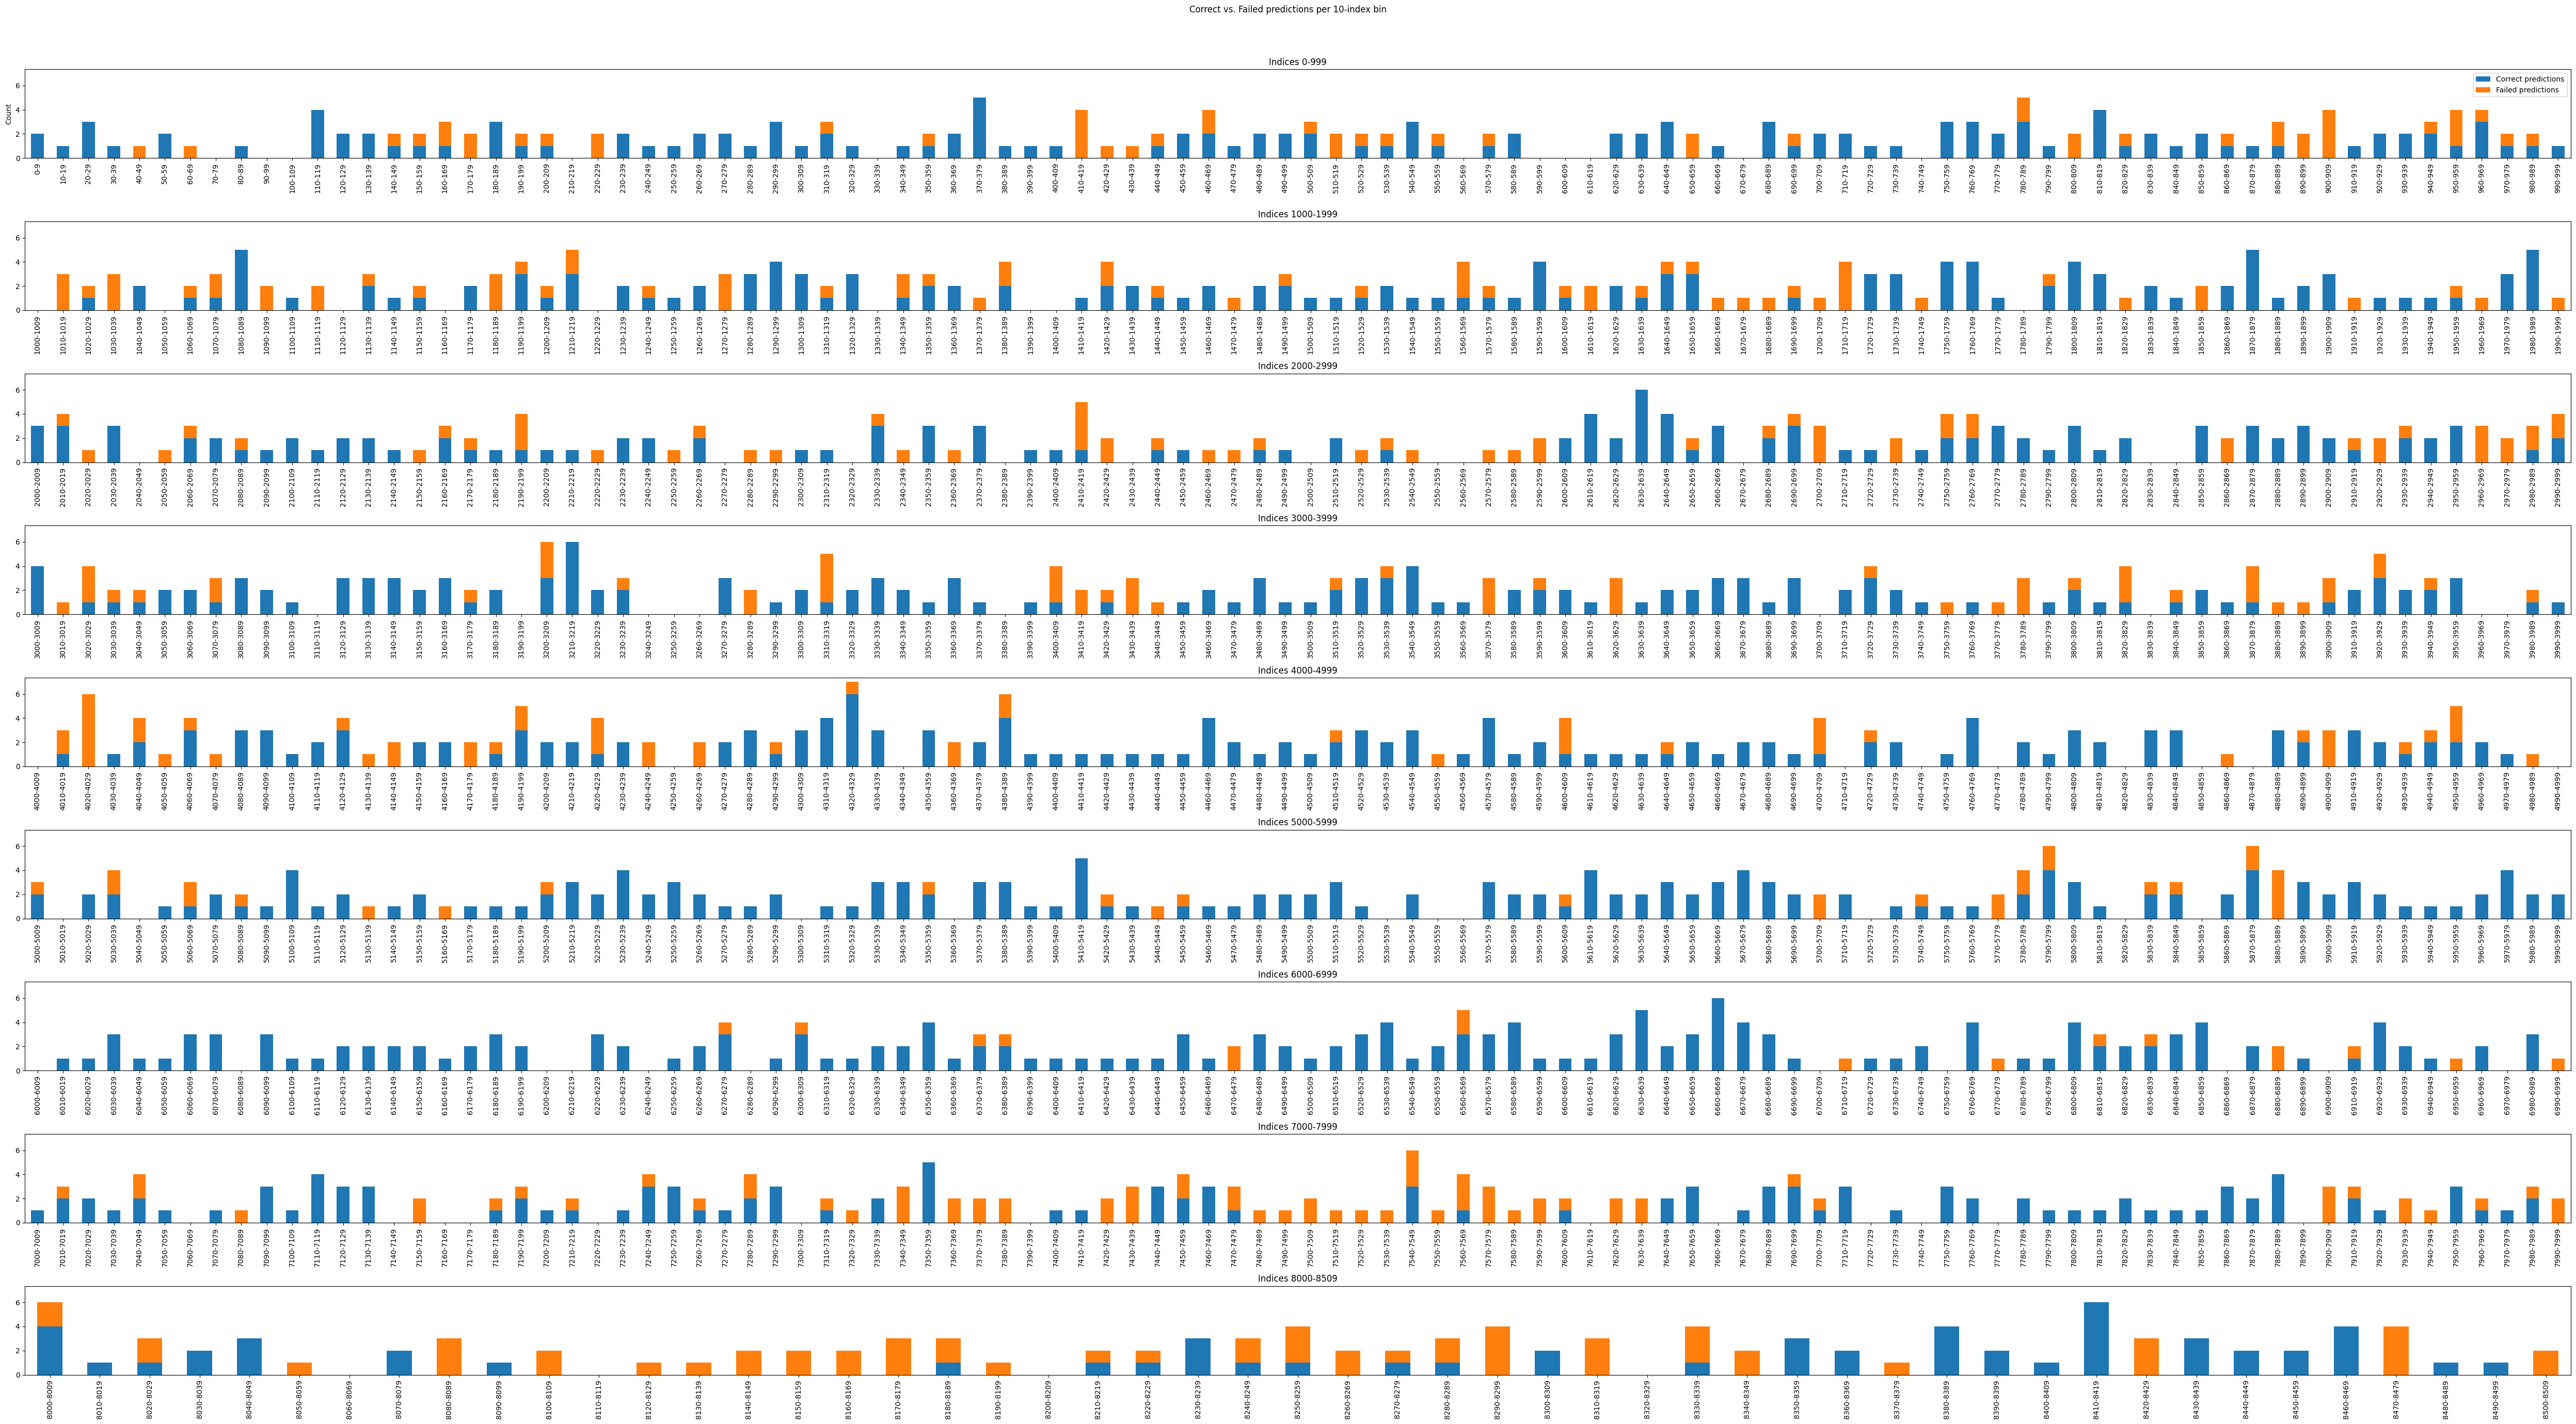

In [7]:
import math

bins = np.arange(0, len(X_test)+len(X_train)+10, 10)
counts,_ = np.histogram(misclassified_lines, bins= bins)
counts_y_test,_ = np.histogram(idx_test, bins= bins)


labels = [f"{bin}-{bin+9}" for bin in bins[:-1]]

df = pd.DataFrame({
    "Range":labels,
    "Correct predictions":counts_y_test - counts,
    "Failed predictions":counts
})

bins_per_subplot = 100
total_bins = len(df)
n_subplots = math.ceil(total_bins / bins_per_subplot)  
fig, axes = plt.subplots(n_subplots, 1, figsize=(50, 3*n_subplots), sharey=True)

if n_subplots == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    start = i * bins_per_subplot
    stop = min((i + 1) * bins_per_subplot, total_bins)
    chunk = df.iloc[start:stop].set_index("Range")

    chunk.plot(kind="bar", stacked=True, ax=ax, legend=(i == 0))

    start_idx = start * 10
    stop_idx = stop * 10 - 1
    ax.set_title(f"Indices {start_idx}-{stop_idx}")

    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=90)

    if i == 0:
        ax.set_ylabel("Count") 

fig.suptitle("Correct vs. Failed predictions per 10-index bin", y=1.02)
fig.tight_layout()
plt.savefig("failed_prediction_counts_batched_1000.png", dpi=150)
plt.show()

### Identification of the position of misclassification in the batch of 10 lins of extraction

In [8]:
import json

def json_analytics(data_array):
    data_json = dict()
    data_json["0"],data_json["1"],data_json["2"],data_json["3"],data_json["4"],data_json["5"],data_json["6"],data_json["7"],data_json["8"],data_json["9"], = 0,0,0,0,0,0,0,0,0,0
    for element in data_array:
        element_to_str = str(element)
        last_integer  = element_to_str[-1]
        data_json[last_integer] = data_json[last_integer] + 1
    return data_json

def json_analytics_data_ind(data_array):
    data_json = dict()
    data_json["0"],data_json["1"],data_json["2"],data_json["3"],data_json["4"],data_json["5"],data_json["6"],data_json["7"],data_json["8"],data_json["9"], = [],[],[],[],[],[],[],[],[],[]
    for element in data_array:
        element_to_str = str(element)
        last_integer  = element_to_str[-1]
        data_json[last_integer].append(element)
    return data_json

def round_percent(ind: str):
    return round(100*int(json_analytics(misclassified_lines)[ind])/int(json_analytics(idx_test)[ind]),2)

def get_roughness_value():
    pass


count_test_per_line = json.dumps(json_analytics(idx_test))
count_fails_per_line = json.dumps(json_analytics(misclassified_lines))
percent_fails_per_line = {"0": f"{round_percent('0')} %", 
                          "1": f"{round_percent('1')} %", 
                          "2": f"{round_percent('2')} %", 
                          "3": f"{round_percent('3')} %", 
                          "4": f"{round_percent('4')} %", 
                          "5": f"{round_percent('5')} %", 
                          "6": f"{round_percent('6')} %", 
                          "7": f"{round_percent('7')} %", 
                          "8": f"{round_percent('8')} %", 
                          "9": f"{round_percent('9')} %"}
print("Count number of test element by line      :",count_test_per_line)
print("Count number of failing prediction by line:",count_fails_per_line)
print("Count percentage of failing prediction by line:",percent_fails_per_line)
print("Array of Index of failed prediction by line:\n",json_analytics_data_ind(misclassified_lines))


Count number of test element by line      : {"0": 170, "1": 159, "2": 170, "3": 154, "4": 164, "5": 184, "6": 180, "7": 168, "8": 167, "9": 186}
Count number of failing prediction by line: {"0": 45, "1": 50, "2": 48, "3": 49, "4": 44, "5": 44, "6": 43, "7": 53, "8": 50, "9": 52}
Count percentage of failing prediction by line: {'0': '26.47 %', '1': '31.45 %', '2': '28.24 %', '3': '31.82 %', '4': '26.83 %', '5': '23.91 %', '6': '23.89 %', '7': '31.55 %', '8': '29.94 %', '9': '27.96 %'}
Array of Index of failed prediction by line:
 {'0': [np.int64(4930), np.int64(8290), np.int64(4050), np.int64(7570), np.int64(7480), np.int64(40), np.int64(1030), np.int64(4950), np.int64(4550), np.int64(5060), np.int64(1420), np.int64(8080), np.int64(970), np.int64(3530), np.int64(3620), np.int64(1560), np.int64(3410), np.int64(3870), np.int64(4220), np.int64(6560), np.int64(940), np.int64(170), np.int64(4640), np.int64(2080), np.int64(7210), np.int64(3820), np.int64(350), np.int64(570), np.int64(3980), n

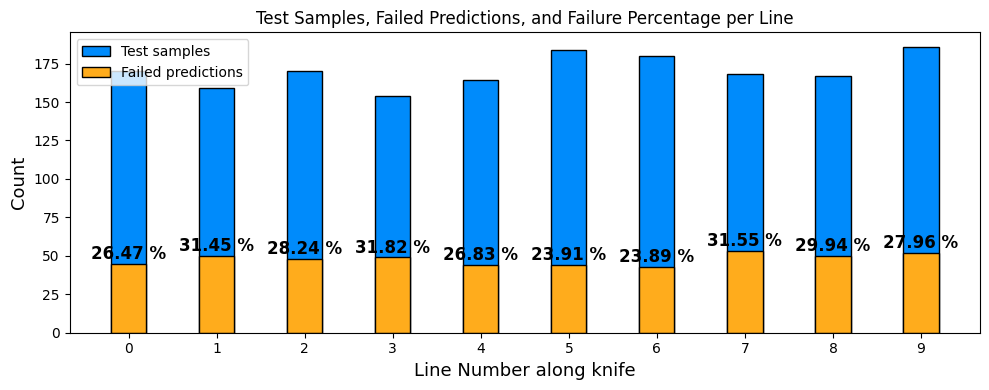

In [9]:
import json

test_counts = json.loads(count_test_per_line)
fail_counts = json.loads(count_fails_per_line)
fail_percents = percent_fails_per_line  

labels = [str(i) for i in range(10)]
test_vals = [test_counts[l] for l in labels]
fail_vals = [fail_counts[l] for l in labels]
percent_vals = [fail_percents[l] for l in labels]

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 4))


bars1 = ax.bar(x, test_vals, width, label='Test samples', color='#008BFB', edgecolor='black')

bars2 = ax.bar(x, fail_vals, width, label='Failed predictions', color='#FFAC1C', edgecolor='black')


for i, (rect, pct) in enumerate(zip(bars2, percent_vals)):
    height = rect.get_height()
    if height > 0:
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.5, pct, ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Line Number along knife', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Test Samples, Failed Predictions, and Failure Percentage per Line', fontsize=12, weight='500')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

### Analyse the reason or feature responsable of failing prediction in each line

In [10]:
def find_first_index(d, value):
    """
   Allow finding  the index of an element for the next code to see the locsl exlanation of the element
    """
    try:
        target = int(value)
    except Exception:
        target = value

    for k, arr in d.items():
        try:
            a = np.asarray(arr)
            hits = np.where(a == target)[0]
            if hits.size:
                return k, int(hits[0])
        except Exception:
            for i, v in enumerate(arr):
                if int(v) == target:
                    return k, i
    raise ValueError(f"{value} not found")

def find_all_indexes(d, value):
    """
    Return a list of all (key, idx) where `value` appears.
    """
    try:
        target = int(value)
    except Exception:
        target = value

    out = []
    for k, arr in d.items():
        try:
            a = np.asarray(arr)
            for i in np.where(a == target)[0]:
                out.append((k, int(i)))
        except Exception:
            for i, v in enumerate(arr):
                if int(v) == target:
                    out.append((k, i))
    return out


In [33]:
key, index = find_first_index(json_analytics_data_ind(misclassified_lines), 8283)
print ("line_number: ",key, "index_failed_element: ", index)

line_number:  3 index_failed_element:  45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class probabilities: [4.598845e-01 5.401155e-01 4.757023e-15]
Predicted class: 1
True class: 0


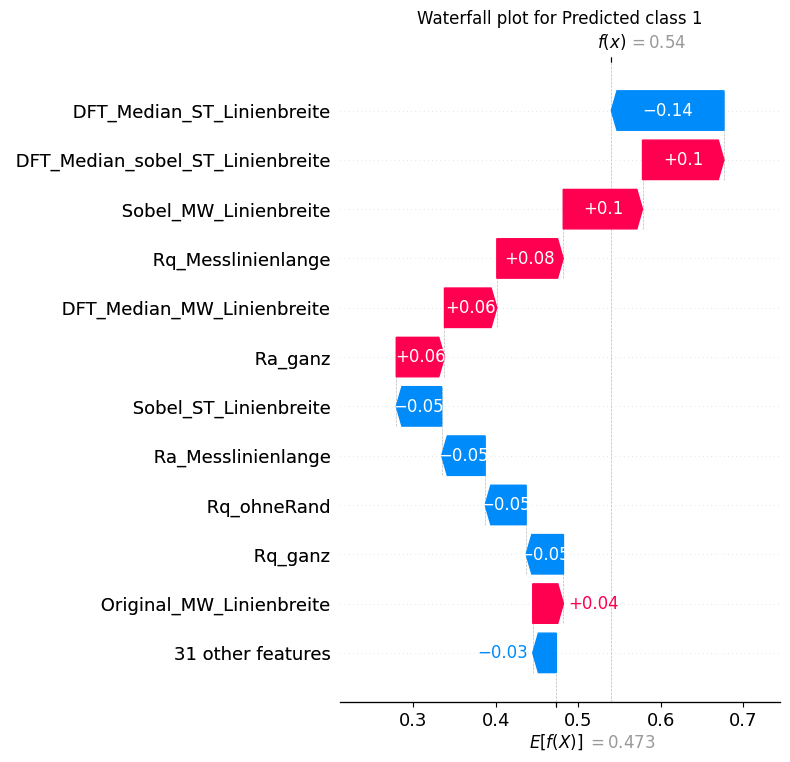

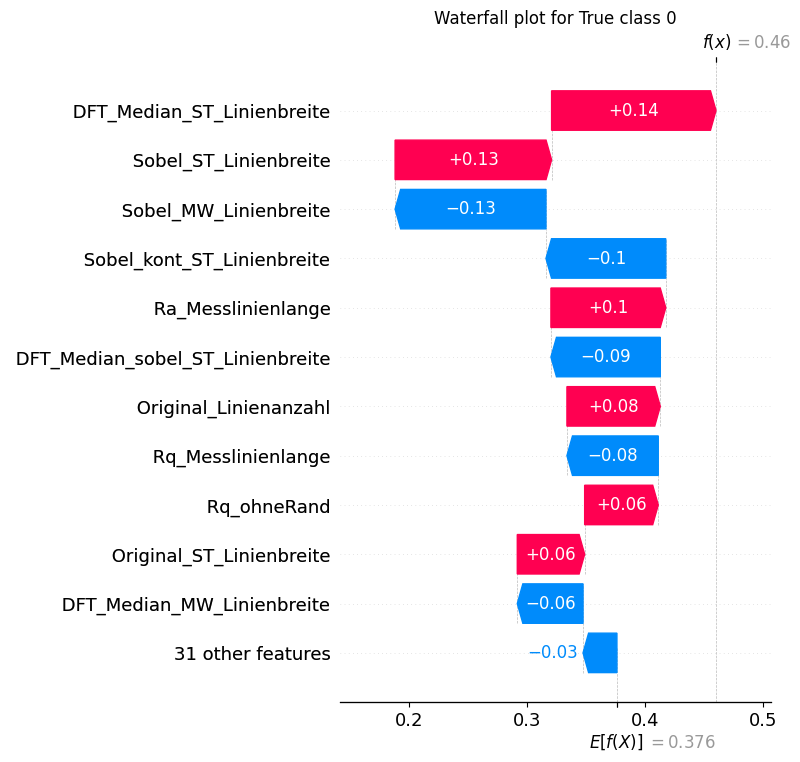

In [34]:
line_number = 3 # 0, 1, 2, 3,...,9
index_failed_element = 45

element_index = json_analytics_data_ind(misclassified_lines)[str(line_number)][index_failed_element]
waterfall_plot(np.where(idx_test==element_index)[0][0])

### Identification of failed predictions in batch of 200 knives

In [13]:
import numpy as np

def make_bins(n_rows, default_step=200, exceptions=None):
    exceptions = exceptions or {}
    edges = [0]
    pos = 0
    while pos < n_rows:
        step = exceptions.get(pos, default_step)
        pos = min(pos + step, n_rows)
        edges.append(pos)
    return np.array(edges)

In [14]:
bins_200 = bins = make_bins(n_rows=len(X_test)+len(X_train), default_step=200,exceptions={1600: 100, 6300: 210})
counts_200,_ = np.histogram(misclassified_lines, bins= bins_200)
counts_y_test_200,_ = np.histogram(idx_test, bins= bins_200)

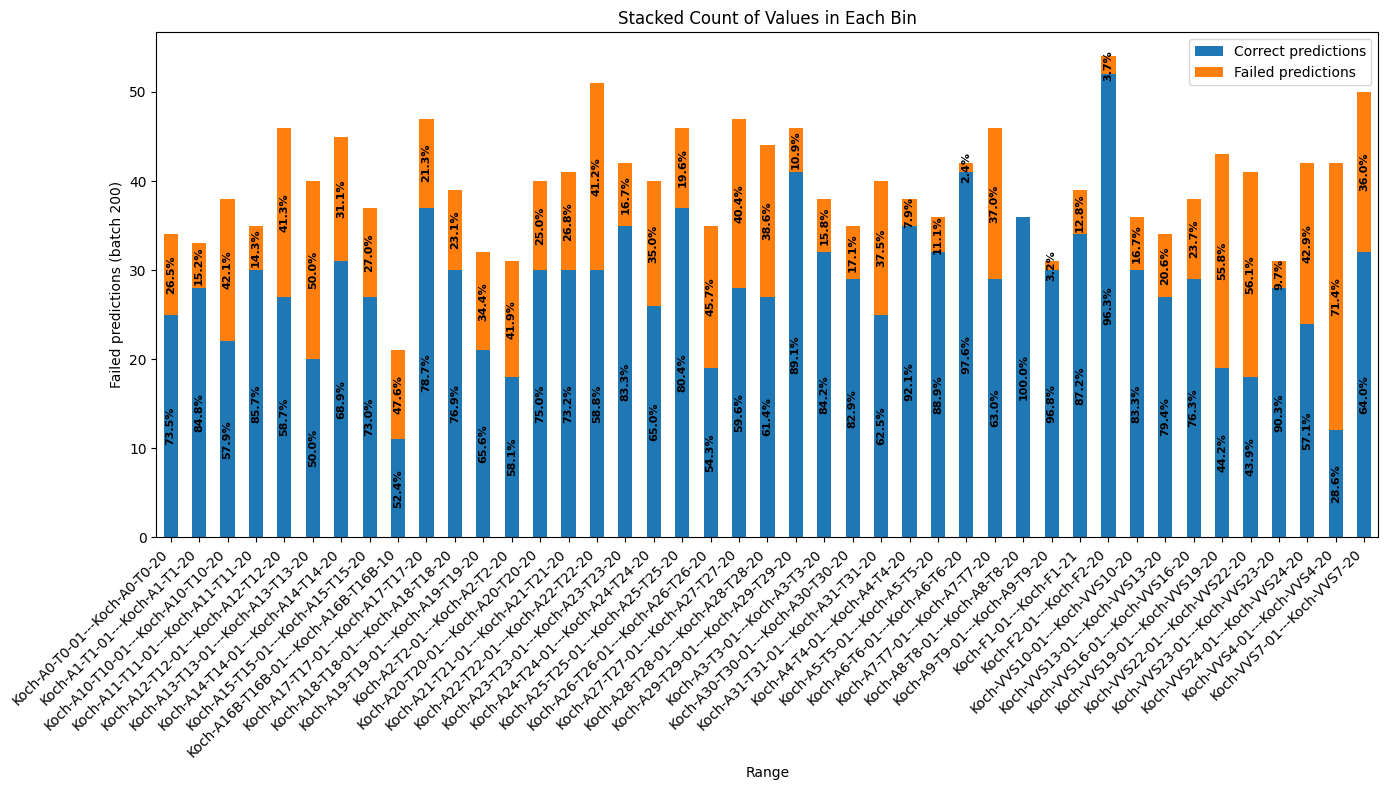

In [15]:
bins_200 = bins = make_bins(n_rows=len(X_test)+len(X_train), default_step=200,exceptions={1600: 100, 6300: 210})
counts_200,_ = np.histogram(misclassified_lines, bins= bins_200)
counts_y_test_200,_ = np.histogram(idx_test, bins= bins_200)


labels_200 = [f"{item1.split('_')[0]}---{item2.split('_')[0]}" for item1,item2 in zip(test_specimen_name[bins_200[:-1]],test_specimen_name[bins_200[1:]-1])]

df_combined = pd.DataFrame({
    "Range":labels_200,
    "Correct predictions":counts_y_test_200 - counts_200,
    "Failed predictions":counts_200
})

ax_200 = df_combined.set_index("Range").plot(kind="bar",stacked=True,figsize=(14,8))
ax_200.set_ylabel("Failed predictions (batch 200)")
ax_200.set_title("Stacked Count of Values in Each Bin")

for i, (correct, failed) in enumerate(zip(df_combined["Correct predictions"], df_combined["Failed predictions"])):
    total = correct + failed
    if total > 0:
        correct_pct = f"{(correct / total) * 100:.1f}%"
        failed_pct = f"{(failed / total) * 100:.1f}%"
        if correct > 0:
            ax_200.text(i, correct / 2, correct_pct, ha='center', va='center', color='black', fontsize=8, fontweight='bold', rotation='vertical')
        if failed > 0:
            ax_200.text(i, correct + failed / 2, failed_pct, ha='center', va='center', color='black', fontsize=8, fontweight='bold', rotation='vertical')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("stack_bin_counts_pandas_200.png",dpi=150)
plt.show()

In [16]:
def elements_in_range(values, low, high, include_right=False):
    """
    Return all elements of `values` that fall in [low, high) by default
    """
    values = np.asarray(values)
    if include_right:
        mask = (values >= low) & (values <= high)
    else:
        mask = (values >= low) & (values <  high)
    return values[mask]

def elements_in_bin(values, bins, bin_idx, include_right=False):
    """
    Return elements in `values` that fall inside the bin number
    """
    low, high = bins[bin_idx], bins[bin_idx + 1]
    if include_right and bin_idx == len(bins) - 2:
        return elements_in_range(values, low, high, include_right=True)
    return elements_in_range(values, low, high, include_right=False)

def bucket_by_bins(values, bins):
    """Return a list where i-th item holds the elements inside bin i."""
    values = np.asarray(values)
    out = []
    for i in range(len(bins)-1):
        out.append(elements_in_bin(values, bins, i))
    return out

def retrieve_ra_values(low,high):
    if low not in bins_200 or high not in bins_200:
        print("Value not accepted")
        return
    failed_predictions = elements_in_range(misclassified_lines, low, high) 
    ytest_by_bin = elements_in_range(idx_test, low, high)
    surface_roughness_ra_test_bin=ra[failed_predictions]
    correct_predicted_indexes = ytest_by_bin[~np.isin(ytest_by_bin, failed_predictions)]
    correct_predicted_ra_test_bin = ra[correct_predicted_indexes]
    return failed_predictions,ytest_by_bin,surface_roughness_ra_test_bin,correct_predicted_ra_test_bin,correct_predicted_indexes


In [17]:
failed_predictions,ytest_by_bin,surface_roughness_ra_test_bin,correct_predicted_ra_test_bin,correct_predicted_indexes = retrieve_ra_values(0,200)

In [18]:
def plot_bin_roughness(lower_limit, upper_limit,low_batch_bound,high_batch_bound):
    """
    Draw a scatter: red = failing, blue = correct.
    Vertical lines: lower and upper spec. limits.
    """
    failed_predictions,ytest_by_bin,surface_roughness_ra_test_bin,correct_predicted_ra_test_bin,correct_predicted_indexes = retrieve_ra_values(low_batch_bound,high_batch_bound)
    
    print("All predictions indexes in current bin: ",ytest_by_bin)
    print("Correectly predicted indexes: ",correct_predicted_indexes)
    print("Failed predictions indexes: ",failed_predictions)
    print("Surface roughness of failed predictions: ", surface_roughness_ra_test_bin)
    print("Correectly predicted roughness test data", correct_predicted_ra_test_bin)

    ra_fail = np.asarray(surface_roughness_ra_test_bin, dtype=float)
    ra_ok   = np.asarray(correct_predicted_ra_test_bin, dtype=float)

    y_fail = np.zeros_like(ra_fail, dtype=float)         # 0 line
    y_ok   = np.ones_like(ra_ok, dtype=float)            # 1 line

   
    if ra_fail.size:
        y_fail = y_fail + np.random.uniform(-0.08, 0.08, ra_fail.size)
    if ra_ok.size:
        y_ok   = y_ok   + np.random.uniform(-0.08, 0.08, ra_ok.size)

    plt.figure(figsize=(10, 4))
   
    if ra_ok.size:
        plt.scatter(ra_ok,   y_ok,   s=22, alpha=0.8, label=f"Correct (n={ra_ok.size})",  color="blue")
    if ra_fail.size:
        plt.scatter(ra_fail, y_fail, s=28, alpha=0.9, label=f"Fail (n={ra_fail.size})",   color="red")

    
    plt.axvline(lower_limit, linestyle="-", linewidth=2.5)
    plt.axvline(upper_limit, linestyle="-", linewidth=2.5)

    
    plt.yticks([0, 1], ["Fail", "Correct"])
    plt.xlabel("Surface roughness (RA)")
    plt.title("Predictions vs Spec Limits (bin)")
    plt.legend(loc="upper left")
    plt.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.6)
    plt.show()
    plt.tight_layout()



In [19]:
bins_200

array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1700, 1900,
       2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100,
       4300, 4500, 4700, 4900, 5100, 5300, 5500, 5700, 5900, 6100, 6300,
       6510, 6710, 6910, 7110, 7310, 7510, 7710, 7910, 8110, 8310, 8510])

All predictions indexes in current bin:  [8290 8188 8242 8294 8212 8234 8229 8192 8178 8285 8309 8143 8237 8305
 8296 8243 8185 8263 8182 8131 8255 8286 8257 8270 8161 8222 8231 8176
 8152 8259 8140 8258 8155 8277 8125 8298 8241 8217 8171 8283 8164 8266]
Correectly predicted indexes:  [8234 8285 8309 8237 8305 8182 8270 8222 8231 8259 8241 8217]
Failed predictions indexes:  [8290 8188 8242 8294 8212 8229 8192 8178 8143 8296 8243 8185 8263 8131
 8255 8286 8257 8161 8176 8152 8140 8258 8155 8277 8125 8298 8171 8283
 8164 8266]
Surface roughness of failed predictions:  [0.12 0.12 0.11 0.12 0.11 0.13 0.11 0.1  0.12 0.12 0.11 0.12 0.11 0.1
 0.1  0.09 0.1  0.11 0.1  0.09 0.12 0.1  0.09 0.12 0.11 0.12 0.1  0.09
 0.11 0.11]
Correectly predicted roughness test data [0.11 0.09 0.11 0.11 0.11 0.12 0.12 0.13 0.11 0.1  0.11 0.11]


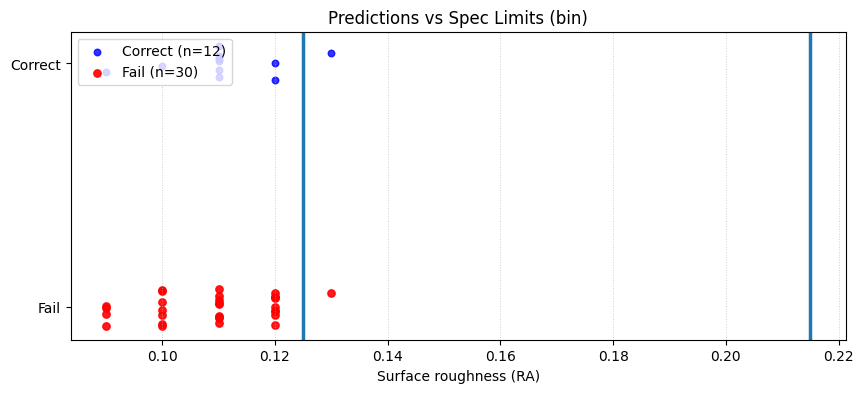

In [20]:
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215
plot_bin_roughness(LOWER_SPECIFICATION_LIMIT,UPPER_SPECIFICATION_LIMIT,8110,8310)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_bin_roughness(lower_limit, upper_limit, low_batch_bound, high_batch_bound, ax=None):
    """
    Draw a scatter: red = failing, blue = correct.
    Vertical lines: lower and upper spec. limits.
    Returns the figure so we can save it elsewhere.
    """
    failed_predictions, _, surface_roughness_ra_test_bin, correct_predicted_ra_test_bin,_ = \
        retrieve_ra_values(low_batch_bound, high_batch_bound)

    ra_fail = np.asarray(surface_roughness_ra_test_bin, dtype=float)
    ra_ok   = np.asarray(correct_predicted_ra_test_bin, dtype=float)

    y_fail = np.zeros_like(ra_fail, dtype=float)
    y_ok   = np.ones_like(ra_ok, dtype=float)

    if ra_fail.size:
        y_fail = y_fail + np.random.uniform(-0.08, 0.08, ra_fail.size)
    if ra_ok.size:
        y_ok   = y_ok   + np.random.uniform(-0.08, 0.08, ra_ok.size)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        fig = ax.figure

    if ra_ok.size:
        ax.scatter(ra_ok,   y_ok,   s=22, alpha=0.8, label=f"Correct (n={ra_ok.size})",  color="blue")
    if ra_fail.size:
        ax.scatter(ra_fail, y_fail, s=28, alpha=0.9, label=f"Fail (n={ra_fail.size})",   color="red")

    ax.axvline(lower_limit, linestyle="-", linewidth=2.5)
    ax.axvline(upper_limit, linestyle="-", linewidth=2.5)

    ax.set_yticks([0, 1], ["Fail", "Correct"])
    ax.set_xlabel("Surface roughness (RA)")
    ax.set_title(f"Predictions vs Spec Limits (bin {low_batch_bound}–{high_batch_bound})")
    ax.legend(loc="upper left")
    ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.6)
    fig.tight_layout()
    return fig

def save_all_bins_to_pdf(lower_limit, upper_limit, bounds, pdf_path="bins.pdf"):
    """
    bounds: np.array([...]) like you showed, length 44 => 43 bins.
    """
    with PdfPages(pdf_path) as pdf:
        for lo, hi in zip(bounds[:-1], bounds[1:]):
            fig = plot_bin_roughness(lower_limit, upper_limit, lo, hi)
            pdf.savefig(fig)
            plt.close(fig)

# usage
BOUNDS = np.array([0,200,400,600,800,1000,1200,1400,1600,1700,1900,2100,2300,2500,2700,
                   2900,3100,3300,3500,3700,3900,4100,4300,4500,4700,4900,5100,5300,5500,
                   5700,5900,6100,6300,6510,6710,6910,7110,7310,7510,7710,7910,8110,8310,8510])

save_all_bins_to_pdf(LOWER_SPECIFICATION_LIMIT, UPPER_SPECIFICATION_LIMIT, BOUNDS, "roughness_bins.pdf")


### **3.2. Global Explanation with SHAP**

All our plot here are based again on the official documentation of SHAP


<Figure size 640x480 with 0 Axes>

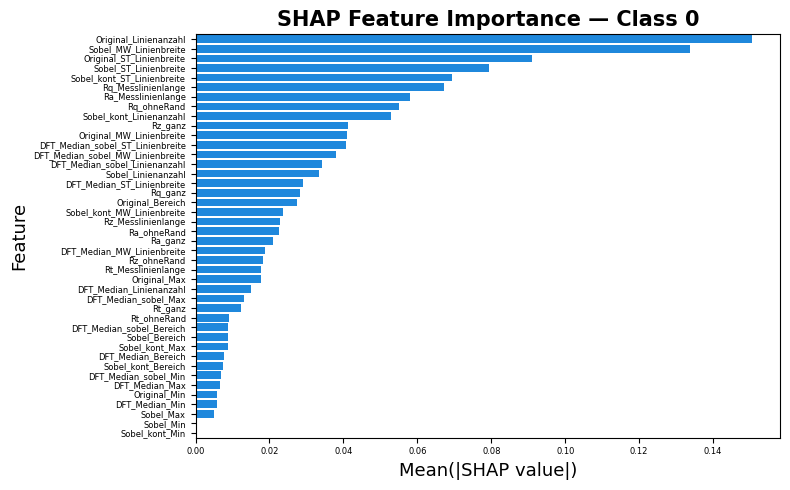

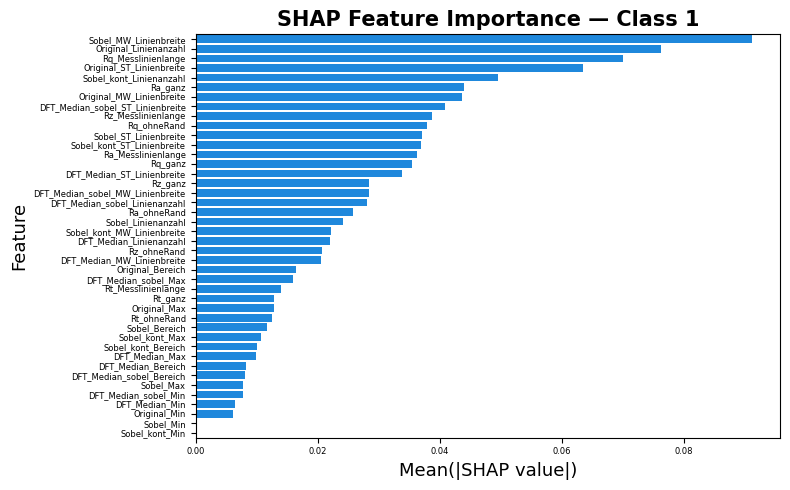

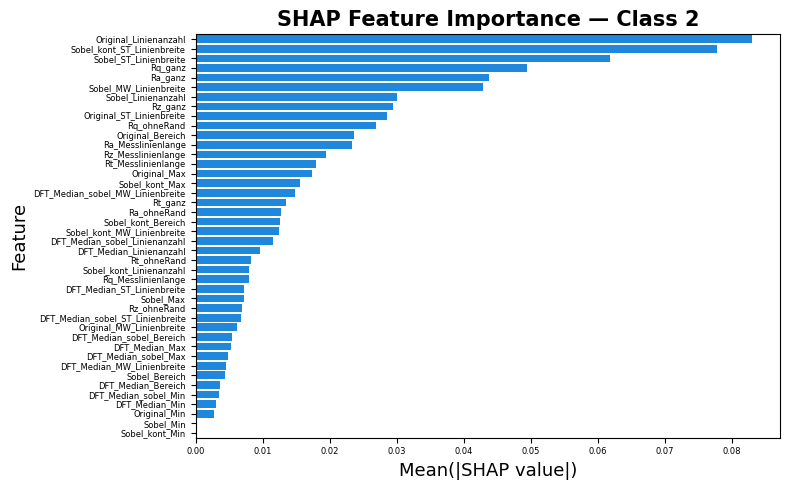

In [22]:
n_classes = len(shap_values_list)
class_names = ['Class 0', 'Class 1', 'Class 2']
top_n = 42

for i in range(n_classes):
    importances = np.abs(shap_values_list[i]).mean(axis=0)
    df = pd.DataFrame({
        'feature': np.array(features),
        'mean_abs_shap': importances
    }).sort_values('mean_abs_shap', ascending=False).iloc[:top_n]
    # df = df[::-1]

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df,
        x='mean_abs_shap',
        y='feature',

        color='#008BFB',
        dodge=False,
        legend=False
    )
    plt.title(f"SHAP Feature Importance — {class_names[i]}", fontsize=15, weight='bold')
    plt.xlabel("Mean(|SHAP value|)", fontsize=13)
    plt.ylabel("Feature", fontsize=13)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


#### Interpretation:

The bar plot quantifies the average absolute impact of each feature on model predictions.  
This ranking is crucial for process engineers or scientists to prioritize which parameters to monitor or optimize.

### **Beeswarm Plot**

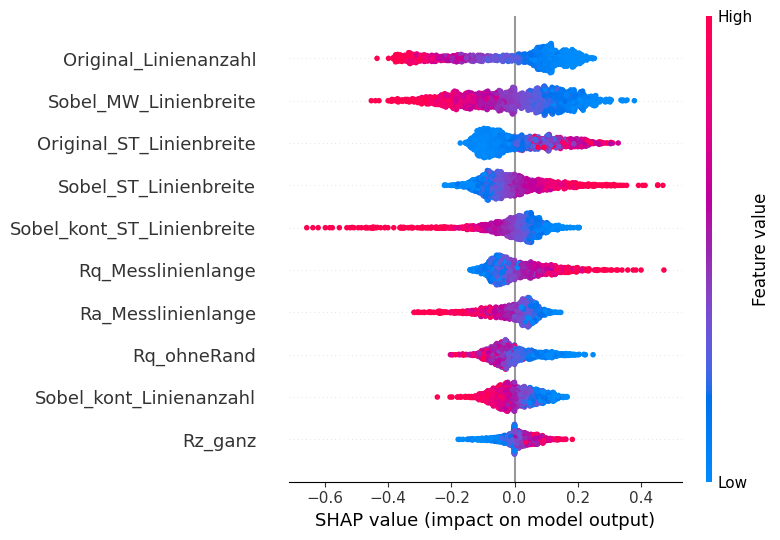

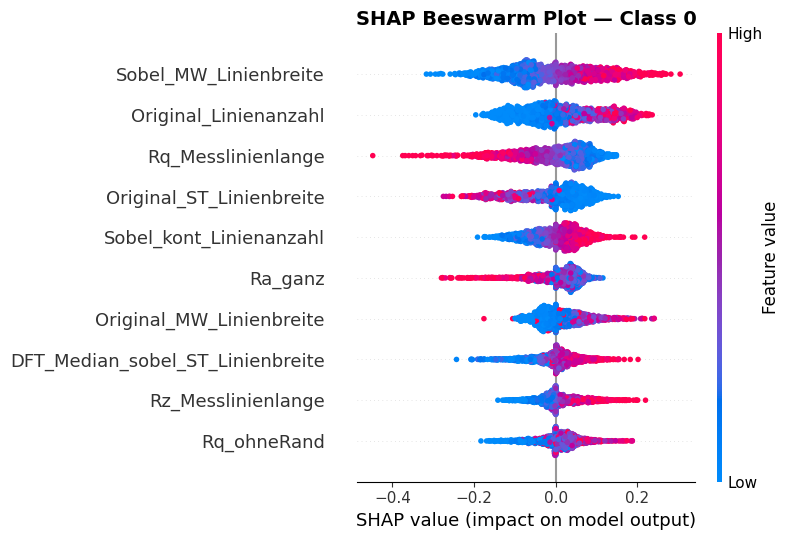

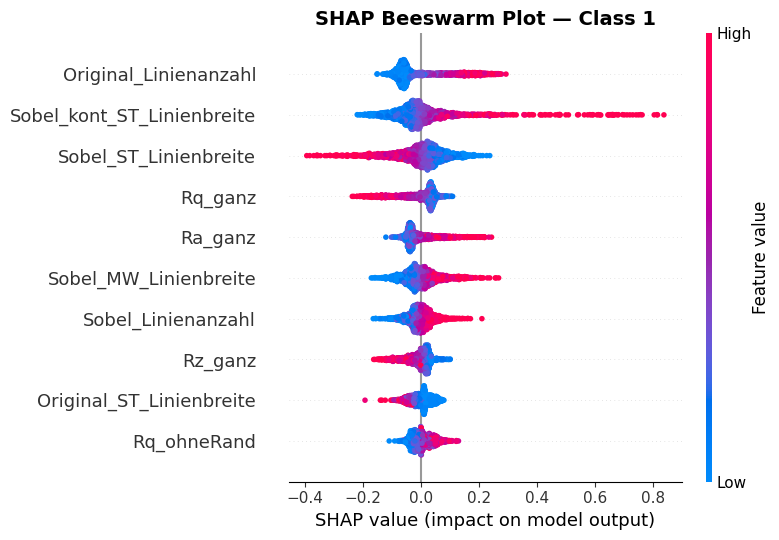

In [23]:
n_classes = len(shap_values_list)
class_names = ['Class 0', 'Class 1', 'Class 2']
top_n = 10

for i in range(n_classes):
    shap.summary_plot(
        shap_values_list[i],
        X_test_df,
        feature_names=features,
        max_display=top_n,
        show=True
    )
    plt.title(f"SHAP Beeswarm Plot — {class_names[i]}", fontsize=14, weight='bold')
    plt.gca().tick_params(axis='y', labelsize=10)
    plt.gca().tick_params(axis='x', labelsize=10)
    plt.tight_layout()


#### **Dependency Plots**

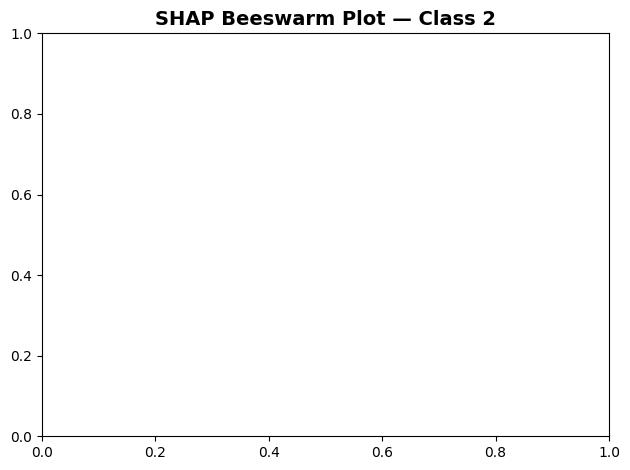

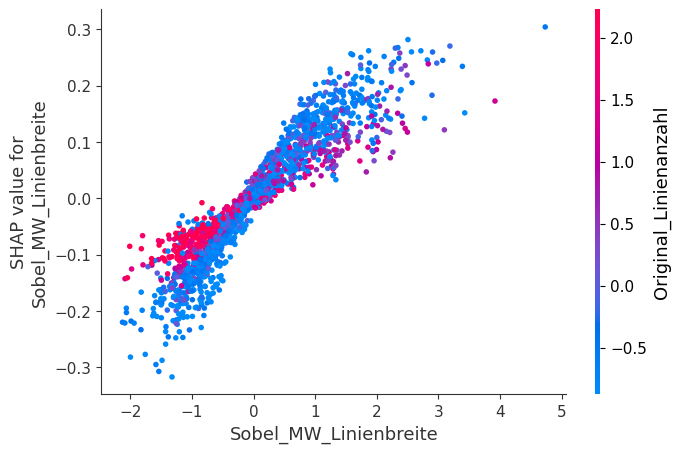

In [24]:
# for one class
top_feature_idx = np.abs(shap_values_list[1]).mean(axis=0).argmax()
top_feature = features[top_feature_idx]
shap.dependence_plot(top_feature, shap_values_list[1], X_test_df, feature_names=features)

#### Interpretation:

This dependence plot shows how changing a single feature value influences the predicted class probabilities.  
For example, as `DFT_Median_sobel_Bereich` increases, the probability of classifying as a certain class might increase, decrease, or follow a more complex pattern.  
It reveals non-linear and interaction effects, critical for scientific process understanding.

### 3.3 SHAP Dependence Plots

From Here nicht gebraucht

In [25]:
top_features = [
    features[np.abs(shap_values_list[i]).mean(axis=0).argmax()]
    for i in range(n_classes)
]
print("Top features per class:", top_features)


Top features per class: ['Original_Linienanzahl', 'Sobel_MW_Linienbreite', 'Original_Linienanzahl']


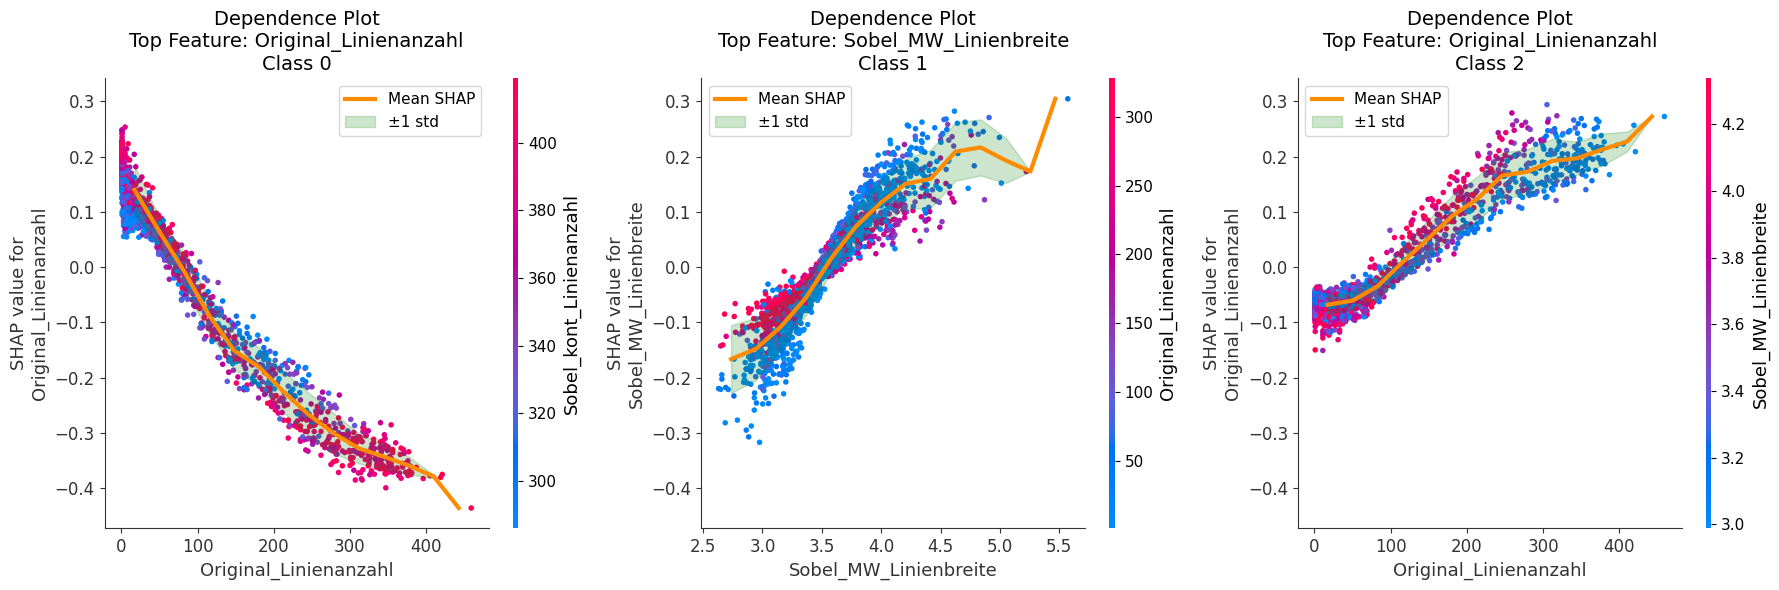

In [26]:
fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 6), sharey=True)

for i in range(n_classes):

    shap.dependence_plot(
        top_features[i],
        shap_values_list[i],
        scaler.inverse_transform(X_test_df),
        feature_names=features,
        ax=axes[i],
        show=False

    )
    axes[i].set_title(f'Dependence Plot\nTop Feature: {top_features[i]}\nClass {i}', fontsize=14)
    axes[i].tick_params(axis='both', labelsize=12)


    fidx = list(features).index(top_features[i])
    xvals = scaler.inverse_transform(X_test_df)[:, fidx]
    yvals = shap_values_list[i][:, fidx]

    bins = np.linspace(np.min(xvals), np.max(xvals), 15)
    bin_centers = 0.5*(bins[1:] + bins[:-1])

    mean_shap, _, _ = binned_statistic(xvals, yvals, statistic='mean', bins=bins)
    std_shap, _, _  = binned_statistic(xvals, yvals, statistic='std', bins=bins)

    axes[i].plot(bin_centers, mean_shap, color='darkorange', lw=3, label='Mean SHAP')
    axes[i].fill_between(bin_centers, mean_shap-std_shap, mean_shap+std_shap,
                        color='green', alpha=0.2, label='±1 std')
    axes[i].legend(fontsize=11)

plt.tight_layout()
plt.show()



Comparison of feature impact on classes

In [27]:
shap_array = np.stack(shap_values_list)

global_feature_importance = np.abs(shap_array).mean(axis=(0, 1))
global_top_feature_idx = global_feature_importance.argmax()
global_top_feature = features[global_top_feature_idx]

print("Globally most important feature:", global_top_feature)


Globally most important feature: Original_Linienanzahl


In [28]:
#List of feature
top_features = [global_top_feature] * n_classes

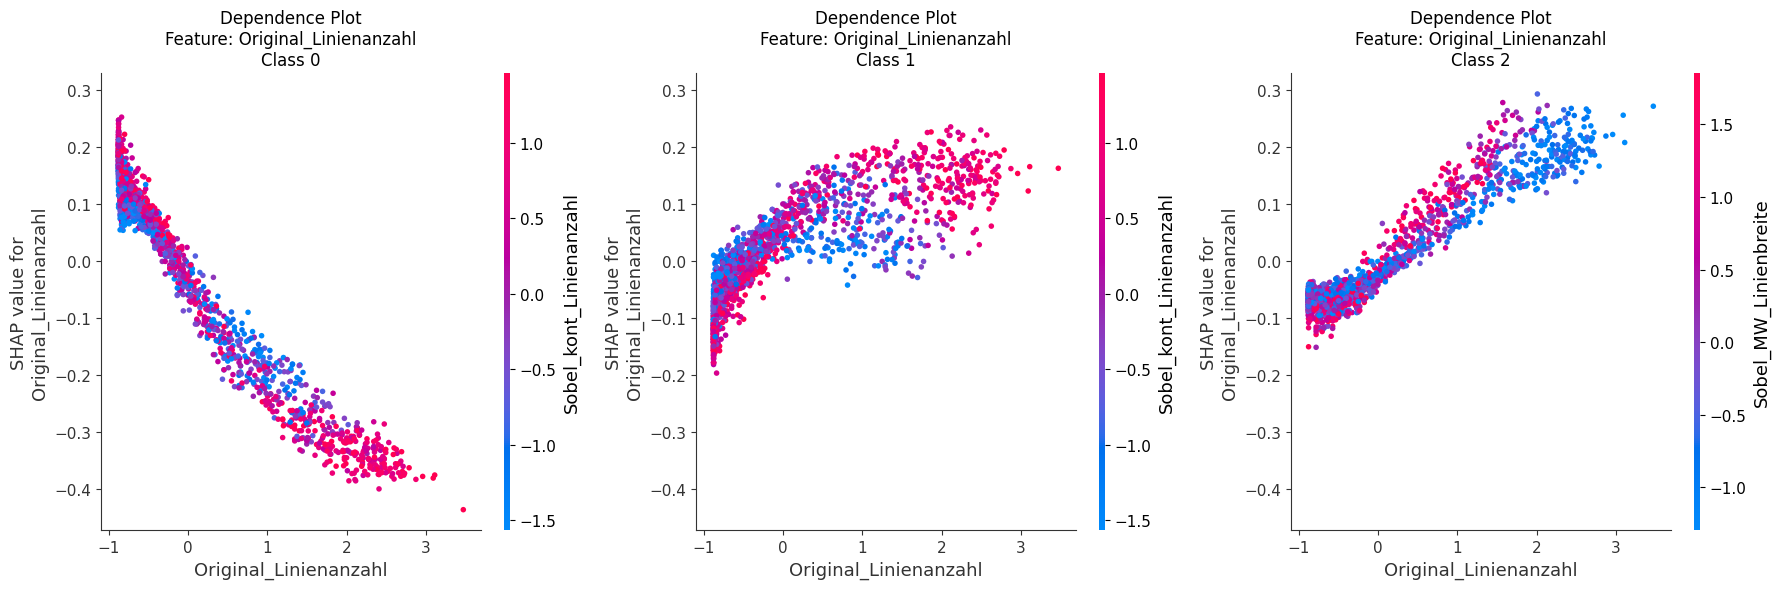

In [29]:
# Dependency plot comparison
fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 6), sharey=True)

for i in range(n_classes):
    shap.dependence_plot(
        global_top_feature,
        shap_values_list[i],
        X_test_df,
        feature_names=features,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f"Dependence Plot\nFeature: {global_top_feature}\nClass {i}")

plt.tight_layout()
plt.show()


# **4. Feature Importance Across Classes**
#### **Class-Specific Summary Plots**

In multi-class problems, it’s valuable to see what features drive predictions to each specific class. SHAP enables class-wise summary plots, showing unique fingerprints for each class.



SHAP summary for Class 1


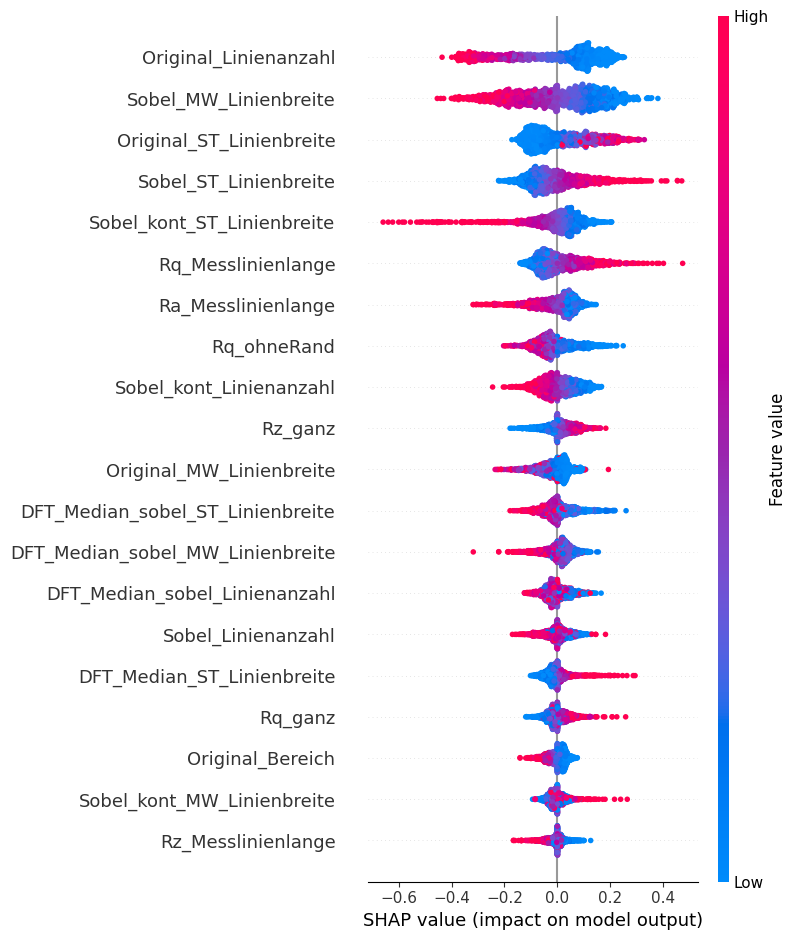

SHAP summary for Class 2


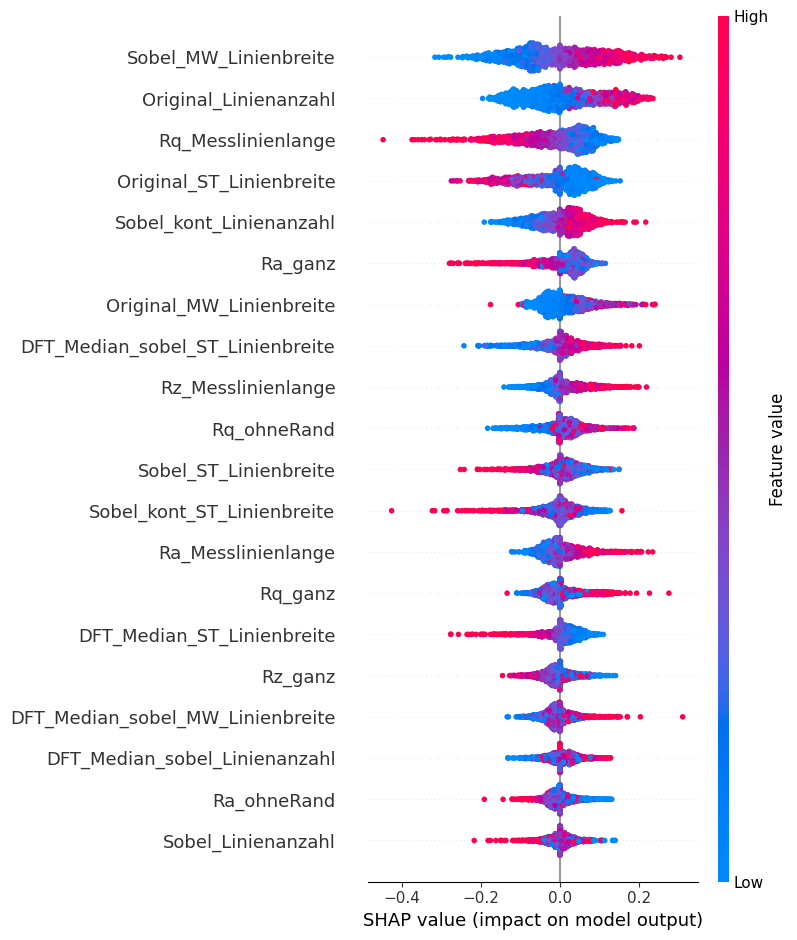

SHAP summary for Class 3


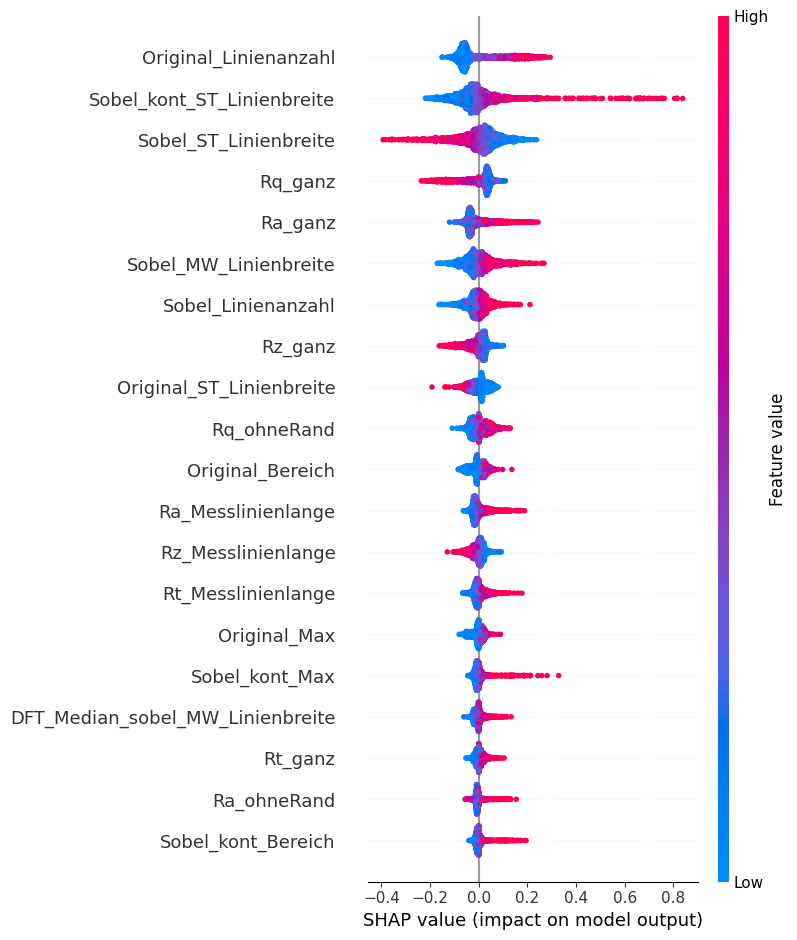

In [30]:
for i, class_name in enumerate(['Class 1', 'Class 2', 'Class 3']):
    print(f"SHAP summary for {class_name}")
    shap.summary_plot(shap_values_list[i], X_test_df, feature_names=features)


**Interpretation:**  
- Features important for distinguishing one class from another can differ.  
- Presenting class-wise importance is useful for scientific investigation of what physically differentiates categories (e.g., acceptable vs. non-acceptable surface).


# **5. Correlation of SHAP with Physical Parameters**

In [31]:
important_feats = pd.Series(np.abs(shap_values_list).mean(axis=(0,1)), index=features).sort_values(ascending=False)
print("Most important features by SHAP (mean abs value):")
print(important_feats.head(10))


Most important features by SHAP (mean abs value):
Original_Linienanzahl         0.103306
Sobel_MW_Linienbreite         0.089306
Sobel_kont_ST_Linienbreite    0.061359
Original_ST_Linienbreite      0.061041
Sobel_ST_Linienbreite         0.059430
Rq_Messlinienlange            0.048421
Rq_ohneRand                   0.040013
Ra_Messlinienlange            0.039171
Rq_ganz                       0.037754
Sobel_kont_Linienanzahl       0.036790
dtype: float64


# **7. Save Figures**

In [32]:
# Save all SHAP plots
plt.savefig('shap_summary.png')

# **References**
- Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). "Why should I trust you?": Explaining the predictions of any classifier." SIGKDD.
- Friedman, J. H. (2001). "Greedy function approximation: A gradient boosting machine." Annals of Statistics.
- Goldstein, A., Kapelner, A., Bleich, J., & Pitkin, E. (2015). "Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation." JCGS.